### Zadanie 2.

Zadaniem jest określenie typów wina na podstawie poniższego zbioru danych: https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_wine.html

1. Przeprowadź krótką wstępną analizę danych
2. Opracuj model klasyfikacyjny w oparciu o xgboost
3. Opracuj model klasyfikacyjny w oparciu o prostą sieci neuronową
4. Przeprowadź trening i walidację wyników dla obu modeli
5. Sprawdź jak zmiana parametrów i architektury Twojej sieci wpływa na wyniki i przedstaw swoje obserwacje - czy któryś z modeli jest lepszy?

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

# KROK 1: WSTĘPNA ANALIZA

In [5]:
# Zaimortowanie bazy danych
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data'
df = pd.read_csv(url, header=None)
column_names = ['class', 'alcohol', 'malic_acid', 'ash', 'alcalinity_of_ash', 'magnesium', 'total_phenols',
                'flavanoids', 'nonflavanoid_phenols', 'proanthocyanins', 'color_intensity', 'hue',
                'diluted_wines', 'proline']
df.columns = column_names
df.head()

,class,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,diluted_wines,proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [6]:
# Zrozumienie danych i analiza
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   class                 178 non-null    int64  
 1   alcohol               178 non-null    float64
 2   malic_acid            178 non-null    float64
 3   ash                   178 non-null    float64
 4   alcalinity_of_ash     178 non-null    float64
 5   magnesium             178 non-null    int64  
 6   total_phenols         178 non-null    float64
 7   flavanoids            178 non-null    float64
 8   nonflavanoid_phenols  178 non-null    float64
 9   proanthocyanins       178 non-null    float64
 10  color_intensity       178 non-null    float64
 11  hue                   178 non-null    float64
 12  diluted_wines         178 non-null    float64
 13  proline               178 non-null    int64  
dtypes: float64(11), int64(3)
memory usage: 19.6 KB


In [7]:
df.describe()

,class,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,diluted_wines,proline
count,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000
mean,1.938202,13.000618,2.336348,2.366517,19.494944,99.741573,2.295112,2.029270,0.361854,1.590899,5.058090,0.957449,2.611685,746.893258
std,0.775035,0.811827,1.117146,0.274344,3.339564,14.282484,0.625851,0.998859,0.124453,0.572359,2.318286,0.228572,0.709990,314.907474
min,1.000000,11.030000,0.740000,1.360000,10.600000,70.000000,0.980000,0.340000,0.130000,0.410000,1.280000,0.480000,1.270000,278.000000
25%,1.000000,12.362500,1.602500,2.210000,17.200000,88.000000,1.742500,1.205000,0.270000,1.250000,3.220000,0.782500,1.937500,500.500000
50%,2.000000,13.050000,1.865000,2.360000,19.500000,98.000000,2.355000,2.135000,0.340000,1.555000,4.690000,0.965000,2.780000,673.500000
75%,3.000000,13.677500,3.082500,2.557500,21.500000,107.000000,2.800000,2.875000,0.437500,1.950000,6.200000,1.120000,3.170000,985.000000
max,3.000000,14.830000,5.800000,3.230000,30.000000,162.000000,3.880000,5.080000,0.660000,3.580000,13.000000,1.710000,4.000000,1680.000000


In [8]:
df.shape

(178, 14)

In [9]:
df.isnull().sum()

class                   0
alcohol                 0
malic_acid              0
ash                     0
alcalinity_of_ash       0
magnesium               0
total_phenols           0
flavanoids              0
nonflavanoid_phenols    0
proanthocyanins         0
color_intensity         0
hue                     0
diluted_wines           0
proline                 0
dtype: int64

<AxesSubplot:xlabel='class', ylabel='count'>

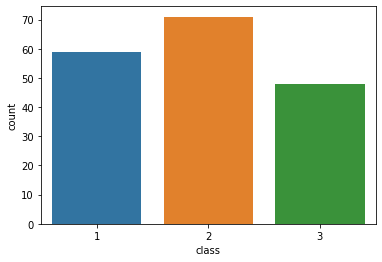

In [10]:
# Wizualizacje
sns.countplot(data=df,x='class')

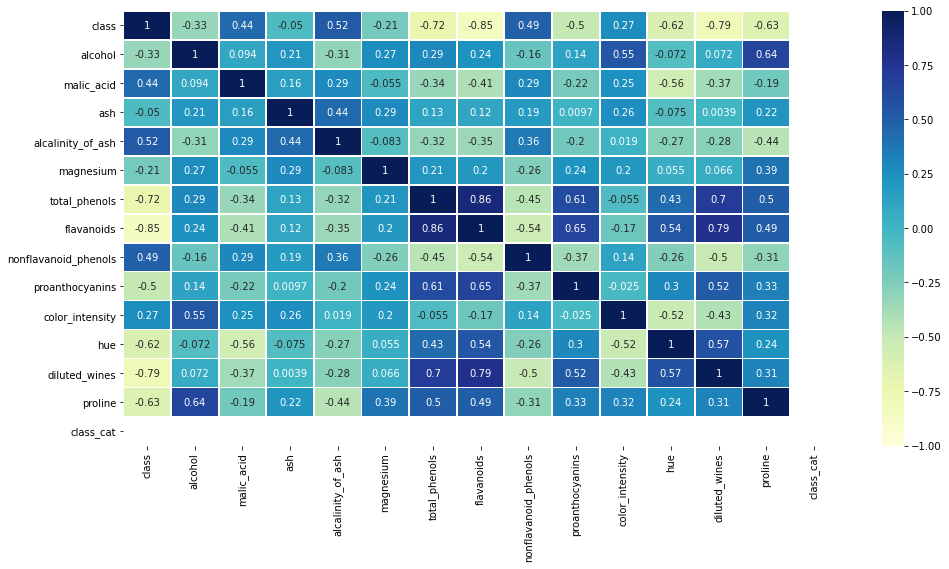

In [11]:
# sprawdzenie korelacji
df['class_cat'] = (df['class'] != 0).astype('int8')

plt.rcParams['figure.figsize']=(16,8)
sns.heatmap(df.corr(method='pearson',), vmax=1., vmin=-1., annot=True, linewidths=.8, cmap="YlGnBu");

In [12]:
sns.pairplot(df,hue='class')

c:\Users\Mateusz\anaconda3\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
c:\Users\Mateusz\anaconda3\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
c:\Users\Mateusz\anaconda3\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


KeyboardInterrupt: 

Error in callback <function flush_figures at 0x0000020EA9DDB160> (for post_execute):


KeyboardInterrupt: 

# KROK 2: PRZYGOTOWANIE DANYCH

In [13]:
# Podział danych na features i target
X = df.drop('class', axis=1)
y = df['class']

In [14]:
# Standaryzacja danych
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)
X = MinMaxScaler().fit_transform(X)

In [16]:
# Podział danych na zbiór treningowy i testowy
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=101)

# Konwersja danych do tensorów PyTorch
X_train = torch.Tensor(X_train)
X_test = torch.Tensor(X_test)
y_train = torch.LongTensor(y_train)
y_test = torch.LongTensor(y_test)

# KROK 3: STWORZENIE MODELU OPARTEGO NA PROSTEJ SIECI NEURONOWEJ

In [21]:
# Definicja prostego modelu sieci neuronowej
class Model(nn.Module):
    def __init__(self, in_features=14, h1=30, out_features=3): #tutaj miałem problem i musiałem zmienić in_features na 14
        super().__init__()
        self.fc1 = nn.Linear(in_features, h1)
        self.fc2 = nn.Linear(h1, out_features)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [34]:
# Tworzenie obiektu modelu sieci neuronowej
model = Model()

# Definicja funkcji straty i optymalizatora
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001) #przy Adam zwykle stosuje się mniejszą wartość lr, ale tu jest dobrze dobrane

# KROK 5: TRENING I WALIDACJA

In [35]:
# Trenowanie modelu
epochs = 1000
losses = []

for epoch in range(epochs):
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

# Przewidywanie na zbiorze testowym
outputs = model(X_test)
_, y_pred_nn = torch.max(outputs, 1)

# Ocena wyników
accuracy_nn = accuracy_score(y_test, y_pred_nn.numpy())
print(f"Accuracy (Neural Network): {accuracy_nn:.4f}")
print("Neural Network Classification Report:")
print(classification_report(y_test, y_pred_nn))

Accuracy (Neural Network): 1.0000
Neural Network Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        14
           1       1.00      1.00      1.00        13
           2       1.00      1.00      1.00         9

    accuracy                           1.00        36
   macro avg       1.00      1.00      1.00        36
weighted avg       1.00      1.00      1.00        36



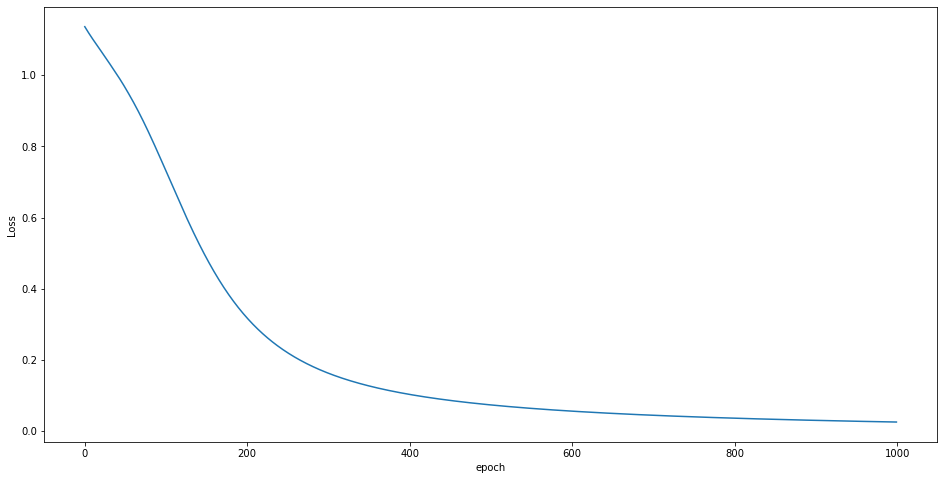

In [36]:
plt.plot(range(epochs), losses)
plt.ylabel('Loss')
plt.xlabel('epoch');

In [37]:
# Ewaluacja całego zbioru testowego
with torch.no_grad():
    y_val = model.forward(X_test)
    loss = criterion(y_val, y_test)
print(f'{loss:.8f}')

0.04794805


In [38]:
correct = 0
with torch.no_grad():
    for i,data in enumerate(X_test):
        y_val = model.forward(data)
        print(f'{i+1:2}. {str(y_val):38}  {y_test[i]}')
        if y_val.argmax().item() == y_test[i]:
            correct += 1
print(f'\n{correct} z {len(y_test)} = {100*correct/len(y_test):.2f}% prawidłowych')

 1. tensor([ 2.9518, -0.6674, -2.7869])     0
 2. tensor([ 2.8971,  0.9291, -4.1996])     0
 3. tensor([-3.3124, -4.0363,  3.7882])     2
 4. tensor([ 7.4391, -2.9655, -3.6984])     0
 5. tensor([-3.4659, -4.4679,  4.2291])     2
 6. tensor([-3.1488,  3.2804, -1.7346])     1
 7. tensor([-2.3486, -4.2897,  3.3250])     2
 8. tensor([ 5.2861, -2.1544, -3.2298])     0
 9. tensor([ 1.3599,  4.4973, -5.7386])     1
10. tensor([ 1.4847,  4.5057, -6.1763])     1
11. tensor([ 5.8528, -2.6241, -3.2946])     0
12. tensor([ 0.4583,  2.9972, -3.9419])     1
13. tensor([ 1.8047, -0.1296, -2.3575])     0
14. tensor([ 2.6341, -0.5935, -2.6003])     0
15. tensor([ 6.5092, -3.2336, -2.9663])     0
16. tensor([ 5.6210, -3.5855, -2.5626])     0
17. tensor([-2.1247,  5.5612, -4.1781])     1
18. tensor([-3.8444, -1.6520,  2.1251])     2
19. tensor([-2.5007,  6.0593, -4.6732])     1
20. tensor([-2.3421,  6.3937, -5.0524])     1
21. tensor([-2.8000,  4.1580, -2.8457])     1
22. tensor([-3.0229, -1.3150,  1.4

In [ ]:
## Generalnie wszystko dobrze. --MM